# Section 11

## Assignment

### Part I: AST4031 and AST5031

1. Generate a dataset with 10 measurements: 30% from a Gaussian distribution with N(0,1), and 70% from N(5,1).
2. Plot the histogram of the dataset. To see how histograms can be misleading, take the positions of the bin centers and shift them by 0.25. Comment on the differences.

     
3. Using the same two-Gaussian model from _Question 1_ generate a new dataset comprising 100 measurements. 
4. Now, use `sklearn.neighbors.KernelDensity` to: 
    1. Plot the available kernels (one way would be to fit your KDE to a null vector)
    2. Perform a kernel density estimation of the distribution of the 100 measurement dataset. Plot this in comparison with your histograms. 
5. Discuss the difference between histogramming and using density estimation.
6. For KDE you need to set the kernel width. Optimize the kernel width using a grid search cross-validation. Use `sklearn.model_selection.GridSearchCV`. 
7. Perform your fit again with 3 different kernels but this time use the optimized kernel width you found above. Compare this to the true PDF for your dataset.

In [1]:
import numpy as np
import sklearn.neighbors as skneigh
import sklearn.model_selection as skmodsel
import scipy.stats as spstats

import astroML.datasets as amldsets

import matplotlib.pyplot as mplplot

%matplotlib inline
%load_ext lab_black

1. To generate the datasets we need we'll define two Normal distributions, with the required means and standard deviations using the `scipy.stats.norm` function. Then we can use the `rvs` method of the distributions to generate the appropriate number of samples. We'll generate two datasets now. One containing 10 samples, and one containing 100 samples, which will be handy later.

In [2]:
## The fraction of our simulated datasets contributed by
## the "standard" N(0,1) Normal component
standardFraction = 0.3
## standard normal
standardNorm = spstats.norm()
## shifted normal
shiftedNorm = spstats.norm(loc=5, scale=1)
## generate datasets
datasets = {
    numSamples: np.concatenate(
        [
            standardNorm.rvs(int(numSamples * standardFraction)),
            shiftedNorm.rvs(int(numSamples * (1 - standardFraction))),
        ]
    )
    for numSamples in [10, 100]
}

2. Now we can plot two histograms of our 10 and 100 sample datasets, one of which has the bin centres shifted by 0.25.

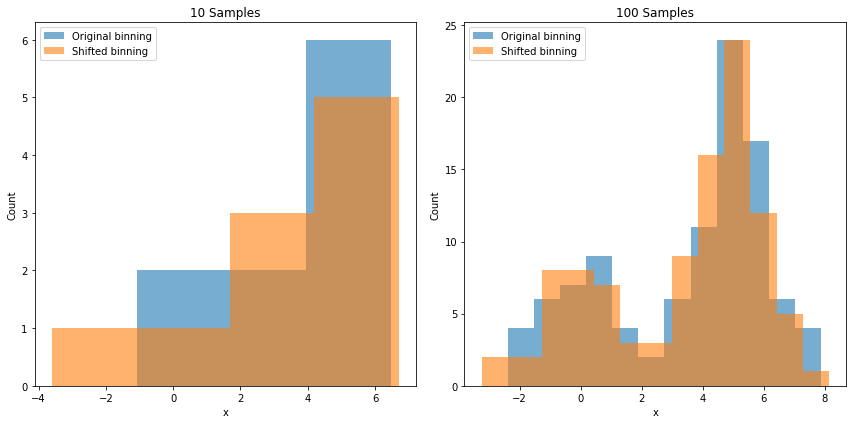

In [3]:
genDataHistFigure, genDataHistPanels = mplplot.subplots(
    figsize=(12, 6), nrows=1, ncols=2
)
for (numSamples, dataset), genDataHistPanel, binCount in zip(
    datasets.items(), genDataHistPanels.flatten(), [10 // 3, 100 // 8]
):

    ## plot histogram of dataset with 10 samples
    hist, bins, _ = genDataHistPanel.hist(
        dataset, bins=binCount, label="Original binning", alpha=0.6
    )

    ## Shift the bins. Add 0.25 to all the bin boundaries and insert
    ## another bin at the beginning to catch any samples that happened
    ## to be within 0,25 of the lower edge of the original bin range.
    binWidth = np.diff(bins[:2])
    shiftedBins = [bins[0] - binWidth] + (bins + 0.25).tolist()

    genDataHistPanel.hist(
        dataset, bins=shiftedBins, label="Shifted binning", alpha=0.6
    )
    genDataHistPanel.set_xlabel("x")
    genDataHistPanel.set_ylabel("Count")
    genDataHistPanel.set_title("{} Samples".format(numSamples))
    genDataHistPanel.legend()
mplplot.tight_layout()

For **this pair** of random realizations dataset, shifting the bins for the 10 sample dataset produces very misleading results. We might guess that there is a peak somewhere around -1, rather than 0, where the standard Normal really peaks. For the larger dataset, the effect is less pronounced, but we can still see how even small shifts in the bin boundaries can produce large fluctuations in the bin contents.

4. As the question suggests, one way to generate plots of the Kernel shapes is to generate a Kernel density estimate of a _null_ vector. A null vector is simply a vector containing only zero values. In our case, because our data are 1-dimensional, we will use a null vector with length one. For $n$-dimensional data, we would use an length-$n$ null vector. The null vector represents a single point at the origin of our $n$-dimensional parameter space. Recall that the Kernel Density estimator will associate a single instance of our chosen kernel shape with each data point in our dataset, so for a null vector, representing a single data point, the Kernel Density estimator will generate a model comprising a single instance of our chosen kernel shape. We can then use the model to compute the probability of observing a data point at **any** location in our parameter space. If we choose a regular grid of parameter values at which to compute the model probability, then we can reconstruct and plot the intrinsic kernel shape. Simple!

    There is of course, one subtlety when using the `sklearn.neighbors.KernelDensity` class. Like many of the classes provided by `sklearn`, `KernelDensity` is designed to generalize to high dimensional parameter spaces. This leads to a  potentially unexpected format requirement for the input data **and** any trial points at which to evaluate the KDE model. The `sklearn` documentation informs us that the input data are required to be in the form of a two dimensional array with shape `[n_samples, n_features]`. What does this mean? Firstly, what are "features" a feature is a generic name for some aspect of the data or even an arbitrary function of the data. For the current example, our data have only one inherent feature, which is their x-coordinate. Later we will see an example of a two dimensional dataset, with two coordinate features. The required data format requires that we supply a **vector** of features for every sample in our dataset. It doesn't matter that our data only have one dimension/feature, we still need to supply a length-1 vector for every sample. We wrap all of these length-1 vectors into an outer vector with length equal to the number of samples, so if we had $m$ samples, our final input or query data structures look something like this.
    \begin{equation}
    \begin{bmatrix}
    [x_{0}]\\
    [x_{1}]\\
    [x_{2}]\\
    \vdots\\
    [x_{m}]
    \end{bmatrix}
    \end{equation}
    For an **n-dimensional** space, with we would supply a structure looking like this.
    \begin{equation}
    \begin{bmatrix}
    [x_{0,0},x_{0,1}\ldots x_{0,n}]\\
    [x_{1,0},x_{1,1}\ldots x_{1,n}]\\
    [x_{2,0},x_{2,1}\ldots x_{2,n}]\\
    \vdots\\
    [x_{m,0},x_{m,1}\ldots x_{m,n}]
    \end{bmatrix}
    \end{equation}
    Okay! With that out of the way we can go ahead and generate our kernel plots. We can get a list of available kernel names from [the `sklearn` documentation](https://scikit-learn.org/stable/modules/density.html#kernel-density).

In [4]:
def plotKernels(
    bandwidths=[1],
    availableKernelNames=[
        "gaussian",
        "tophat",
        "epanechnikov",
        "exponential",
        "linear",
        "cosine",
    ],
):
    ## This is our null vector. It is a 1x1, two dimensional vector, we have 1 sample
    ## comprising 1 feature
    nullVector = np.zeros((1, 1))

    ## This is the range of x values that we will use to sample the KDE models
    ## It brackets the origin of our 1D parameter space.
    abscissae = np.linspace(-4, 4, 200)

    availableKernelFigureShape = np.array((3, len(availableKernelNames) // 3))
    availableKernelFigure, availableKernelPanels = mplplot.subplots(
        figsize=4 * availableKernelFigureShape,
        ncols=availableKernelFigureShape[0],
        nrows=availableKernelFigureShape[1],
    )
    for availableKernelName, availableKernelPanel in zip(
        availableKernelNames, availableKernelPanels.flatten()
    ):
        for bandwidth in bandwidths:
            logDensity = (
                ## Instantiate a KDE estimator, specifying the kernel that we want
                ## it to use when fitting.
                skneigh.KernelDensity(
                    kernel=availableKernelName, bandwidth=bandwidth
                )
                ## Generate a KDE model for our single data point at the origin.
                .fit(nullVector)
                ## Compute the log-probability of observing the points in our
                ## chosen range of x-values for plotting. Note that we expand
                ## the dimensionality of abscissae (this yields a 2D 1x200 array)
                ## and then transpose the result to get a 2D 200x1 array.
                .score_samples(np.atleast_2d(abscissae).T)
            )
            ## Now we just plot the exponentiation of the log-probability.
            availableKernelPanel.plot(
                abscissae, np.exp(logDensity), label="{:.2f}".format(bandwidth)
            )
        availableKernelPanel.set_title(availableKernelName.title())
        availableKernelPanel.set_xlabel("x")
        availableKernelPanel.set_ylabel("KDE")
        availableKernelPanel.legend(title="Bandwidths", loc="upper left")

    availableKernelFigure.suptitle(
        "Kernels provided by sklearn.neighbours.KernelDensity",
        y=1.05,
        fontsize="x-large",
    )
    mplplot.tight_layout()

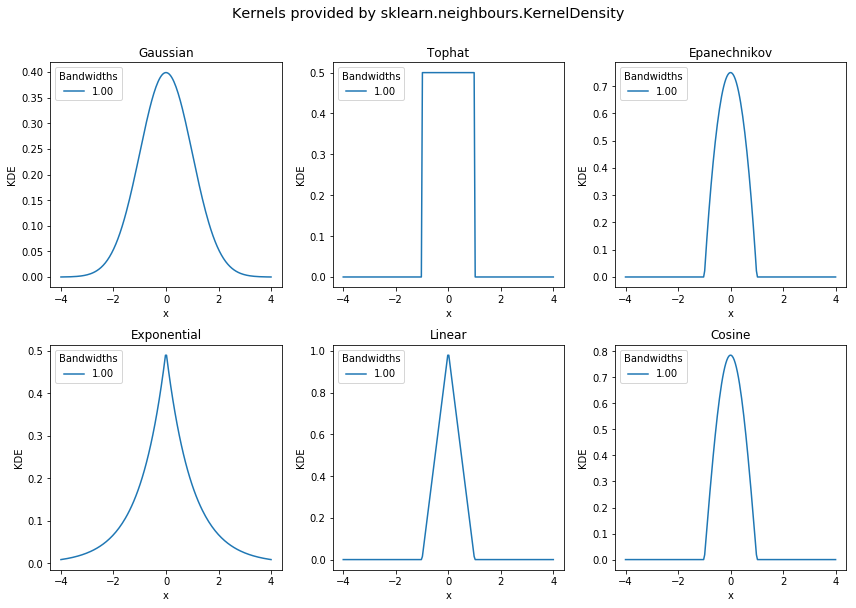

In [5]:
## A list of kernel shapes supplied by sklearn
availableKernelNames = [
    "gaussian",
    "tophat",
    "epanechnikov",
    "exponential",
    "linear",
    "cosine",
]

plotKernels()

Now we can proceed to generate a KDE model for our 100 sample dataset. We'll use exactly the same approach as we did when plotting the kernel shapes.
* Instantiate a `sklearn.neighbors.KernelDensity` object, and pass the desired kernel shape as a constructor argument.
* Use the `fit` method to build a probability model for our 100-sample dataset. We have to make sure that the data are supplied in the correct format using the `numpy.atleast_2d` function and the transpose (`.T`) attribute of the resultant 2D array.
* Use the `score_samples` method to compute the log probability of observing a data point at a range of x values that we are free to choose. In general we'll choose a finely sampled, uniformly spaced grid.

In [6]:
dataset = datasets[100]

dataRangeGrid = np.linspace(dataset.min(), dataset.max(), 200)
dataKde = (
    skneigh.KernelDensity(kernel="gaussian")
    .fit(np.atleast_2d(dataset).T)
    .score_samples(np.atleast_2d(dataRangeGrid).T)
)

Now that we have our model prediction we can plot it in comparison with our original histograms.

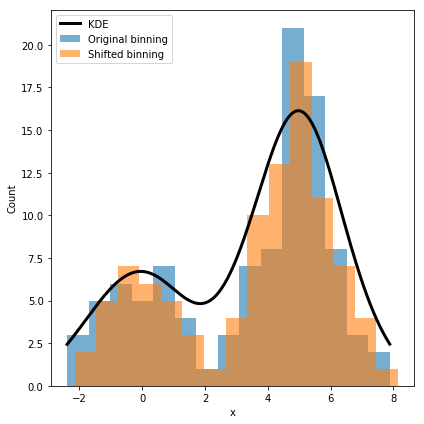

In [7]:
kdeOverHistAxes = mplplot.figure(figsize=(6, 6)).add_subplot(1, 1, 1)
hist, bins, _ = kdeOverHistAxes.hist(
    dataset, bins=15, label="Original binning", alpha=0.6
)
kdeOverHistAxes.hist(
    dataset, bins=bins + 0.25, label="Shifted binning", alpha=0.6
)
kdeOverHistAxes.plot(
    dataRangeGrid,
    np.exp(dataKde) * dataset.size * binWidth,
    label="KDE",
    lw=3,
    c="k",
)
kdeOverHistAxes.set_xlabel("x")
kdeOverHistAxes.set_ylabel("Count")
kdeOverHistAxes.legend()
mplplot.tight_layout()

Great! We generated a smooth representation for the distribution of our discrete data points, but we implicitly chose a specific kernel shape and **more importantly** a particular kernel width. The width of the kernel is controlled by the `bandwidth` parameter of the `GridSearchCV` constructor. Let's quickly use our kernel display code to see how changing the `bandwidth` parameter affects the kernel shape.

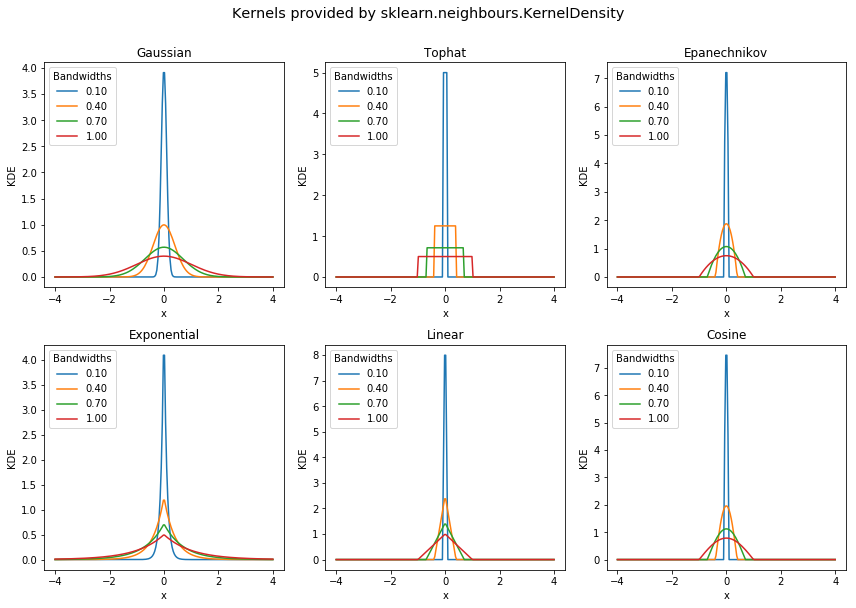

In [8]:
plotKernels(bandwidths=np.linspace(0.1, 1, 4))

Smaller values of the bandwidth produce smaller kernels which will allow our KDE model to pick out finer structures in our data distribution, but if we only have a few datapoints, then the resultand fine-grained model probably doesn't reperesent the true parent distribution that our data points were sampled from. If we use a bandwidth that is too small then we will actually generate a model of our **data** instead of a model for the parent poulation from which our data were drawn. This is called overfitting. Normally, we generate KDE models so that we can generate simulated data samples that we hope are representative of the parent population, so overfitting is not desirable. The appropriate bandwidth to avoid overfitting depends of the complexity of the parent distribution and the degree to which our data sample the distribution. For example, how many data do we have and how well do they sample valid parameter space for the underlying population.

We can use a process called cross-validation to optimize our bandwidth choice. Cross-validation involves the following steps:
1. Choose a range of potential bandwidth values to trial. 
2. Split our data sample into $k$ subsets by randomly sampling **without** replacement. You may read about $k$-fold cross validation - $k$ refers to the number of subsets that the data will be divided into.
3. For all trial bandwidth values:
    1. For all possible unique pairs of subsets:
        1. Compute the KDE using the first subset in the pair, assuming the _current trial bandwidth_.
        2. Compute the total probability of observing the second dataset in the pair, assuming the computed KDE. If you were writing your own cross-validation routine, you could use the `score` method provided by the `KernelDensity` estimator. 
        3. The assumption is that the data samples are independent and therefore that random samples of our full dataset should encode distinct information about different parent population. Both subsets should be consistent with the parent population, but not neccessarily with each other. If our kernel is too small, we will overfit the first data subset and our model will be a poor representation of the second subset, yielding a low total probability. If the kernel is too large, then our model will not capture the details of the parent population and this is also likely to reduce compatibility with the second subset. For the case of the kernel bandwidth cross-validation is better suited to preventing overfitting than underfitting if the individual subsets are indivdually small and only capture a few details of the parent poulation.
    2. Compute the sum of the total probabilities for all pairs, for the _current trial bandwidth_.
4. Select the bandwidth with the maximum total probability.

Luckily, we don't have to write our own cross-validation routine. Instead we can use the `GridSearchCV` class provided in the `sklearn.model_selection` module. To use `GridSearchCV`, we supply a `dict` with keys naming the parameters we want to find optimal values for and corresponding values that are lists or arrays of possible parameter values. In this case we'll only supply a list of values for the `bandwidth` parameter, but cros-validating is a quite generic approach and could be used to find the best values of several parameters. It can even be used for "categorical" parameters like the kernel shape. In this example we'll just assume a _gaussian_ kernel.

`GridSearchCV` accepts several other arguments. The two most important are `estimator`, for wich we will supply an instance of `KernelDensity` constructed to use a _gaussian_ kernel, and `cv`, which is an integer specifying how many subsets our data should be divided into. We'll specify `cv=5` whihch will split our dataset into 5 subsets with 20 unique elements each.

To perform the cross validation, just call the `fit()` method of `GridSearchCV`.

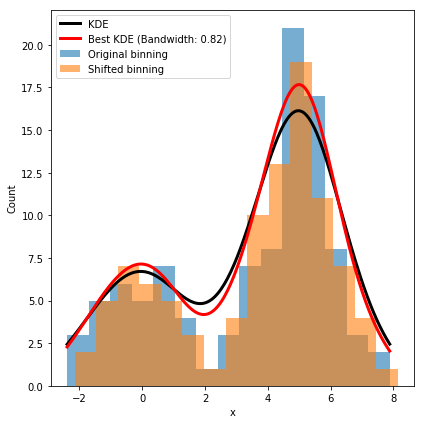

In [9]:
## Test a range of 200 trial bandwidths logarithmically distributed between 1e-3 and 10.
parameters = {"bandwidth": np.logspace(-3, 1, 200)}
## Instantiate the cross-validator
crossValidator = skmodsel.GridSearchCV(
    estimator=skneigh.KernelDensity(kernel="gaussian"),
    param_grid=parameters,
    cv=5,
    iid=True,
)
## Run the cross-validation
crossValidator.fit(np.atleast_2d(dataset).T)

## Now we can retrieve a copy of the KernelDensity instance we supplied
## with the `bandwidth` parameter set to the best value.
## We'll use the score_samples() method to generate a plotable representation
## of our optimal model.
bestDataKde = crossValidator.best_estimator_.score_samples(
    np.atleast_2d(dataRangeGrid).T
)

## Plot histograms of data with optimal KDE estimate
bestKdeOverHistAxes = mplplot.figure(figsize=(6, 6)).add_subplot(1, 1, 1)
hist, bins, _ = bestKdeOverHistAxes.hist(
    dataset, bins=15, label="Original binning", alpha=0.6
)
bestKdeOverHistAxes.hist(
    dataset, bins=bins + 0.25, label="Shifted binning", alpha=0.6
)

bestKdeOverHistAxes.plot(
    dataRangeGrid,
    np.exp(dataKde) * dataset.size * binWidth,
    label="KDE",
    lw=3,
    c="k",
)

bestKdeOverHistAxes.plot(
    dataRangeGrid,
    np.exp(bestDataKde) * dataset.size * binWidth,
    label="Best KDE (Bandwidth: {bandwidth:.2f})".format(
        **crossValidator.best_params_
    ),
    lw=3,
    c="r",
)

bestKdeOverHistAxes.set_xlabel("x")
bestKdeOverHistAxes.set_ylabel("Count")
bestKdeOverHistAxes.legend()
mplplot.tight_layout()

We can clearly see that the optimal kernel width provides a much better representation of the data than the KDE that we generated using the default `bandwidth` value of 1.

Now let's investigate how the choice of kernel **shape** affects the fit. We'll just randomly select three kernel shapes from the list of options (excluding the gaussian we already tried!) and assume the best bandwidth derived in the gaussian case still applies (in general this is probably not true).

We'll also plot the true model distribution that we used to generate our original dataset and explore which of the kernels best approximates it.

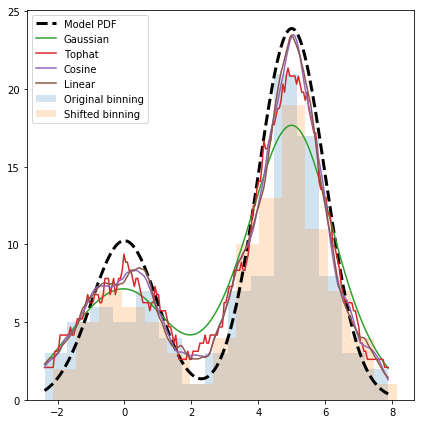

In [10]:
alternateKernelNames = availableKernelNames.copy()
alternateKernelNames.remove("gaussian")
## Choose our 3 alternative kernels
randomKernels = np.random.choice(alternateKernelNames, 3, replace=False)

testKernelAxes = mplplot.figure(figsize=(6, 6)).add_subplot(1, 1, 1)

## Plot the data histograms
hist, bins, _ = testKernelAxes.hist(
    dataset, bins=15, label="Original binning", alpha=0.2
)
testKernelAxes.hist(
    dataset, bins=bins + 0.25, label="Shifted binning", alpha=0.2
)

## plot the model PDF - the true distribution
modelPdf = standardFraction * standardNorm.pdf(dataRangeGrid) + (
    1 - standardFraction
) * shiftedNorm.pdf(dataRangeGrid)

testKernelAxes.plot(
    dataRangeGrid,
    modelPdf * dataset.size * binWidth,
    label="Model PDF",
    ls="--",
    lw=3,
    c="k",
)

## Plot the original gaussian KDE estimate
logDensity = (
    skneigh.KernelDensity(kernel="gaussian", **crossValidator.best_params_)
    .fit(np.atleast_2d(dataset).T)
    .score_samples(np.atleast_2d(dataRangeGrid).T)
)

testKernelAxes.plot(
    dataRangeGrid,
    np.exp(logDensity) * dataset.size * binWidth,
    label="Gaussian",
)
## Plot three non-gaussian KDE estimates
for randomKernel in randomKernels:
    logDensity = (
        skneigh.KernelDensity(
            kernel=randomKernel, **crossValidator.best_params_
        )
        .fit(np.atleast_2d(dataset).T)
        .score_samples(np.atleast_2d(dataRangeGrid).T)
    )

    testKernelAxes.plot(
        dataRangeGrid,
        np.exp(logDensity) * dataset.size * binWidth,
        label=randomKernel.title(),
    )


testKernelAxes.legend()
mplplot.tight_layout()

It seems like the original Gaussian model is a better representation of the data and the true model PDF. This is probably because the alternative kernel shapes are all more sharply peaked and therefore the optimal bandwidth established for the Gaussian kernel is too narrow for the alternatives.

### Part II: AST5031 only
Use the `astroML.datasets.fetch_great_wall` function to import X and Y coordinates of galaxies in the SDSS great wall region. Repeat 4-7 from **Part I** for the **two-dimensional** case, using the galaxies' distribution in 2D as your experimental dataset.

In this part, we'll just be repeating the applicable steps from _Part I_ but making explicit use of the multi-dimensional capabilities of the KDE method. Our data this time will be two-dimensional so we won't need to contrive a 2D structure for our input data or sampling grids. 

The dataset we'll use contains the projected positions of 8014 galaxies that form a large scale cosmological structure known as the _Sloan Great Wall_. The $x$ and $y$ coordinates are derived from the celestial Right Ascension and Declination of the galaxies but in fact represent the physical projected distance between the galaxies (in MPc) if they all lay at the average distance of the wall structure.

We can use the `fetch_great_wall` function provided by the `astroML.datasets` module to retrieve the data.

In [11]:
greatWallXY = amldsets.fetch_great_wall()

Now let's plot the data as 2D histgrams using a couple of binning prescriptions to gauge how much fine detail the dataset contains.

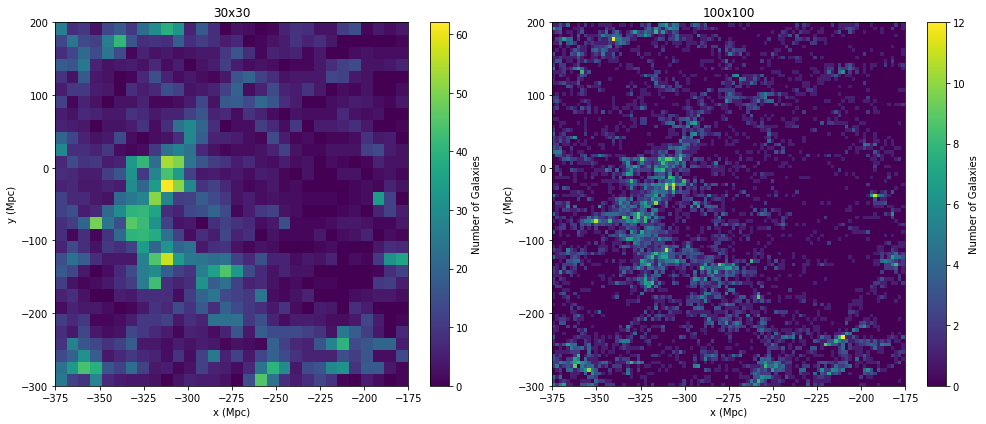

In [12]:
greatWallHistFigure, greatWallHistPanels = mplplot.subplots(
    figsize=(14, 6), nrows=1, ncols=2
)
for binCount, greatWallHistPanel in zip(
    [30, 100], greatWallHistPanels.flatten()
):
    histData = greatWallHistPanel.hist2d(*greatWallXY.T, bins=binCount)
    greatWallHistColourBar = mplplot.colorbar(
        histData[-1], ax=greatWallHistPanel
    )
    greatWallHistColourBar.set_label("Number of Galaxies")
    greatWallHistPanel.set_xlabel("x (Mpc)")
    greatWallHistPanel.set_ylabel("y (Mpc)")
    greatWallHistPanel.set_title("{bc}x{bc}".format(bc=binCount))
mplplot.tight_layout()

Obviously a 30x30 binning grid undersamples the dataset, while a 100x100 grid seems slightly too fine. We'll now use a 2D KDE and cross-validation to try and build an optimal representation of the data.

First, let's generate two-dimensional analogues of the kernel shapes. We'll use the same approach, but this time our null vector will have a single sample comprising a vector of two components (both still zero).

To plot our KDE we'll generate some sampling values using the `numpy.meshgrid` function. This function takes two arrays as input specifying $x$ and $y$ coordinates and generates a dense grid of points for all possible pairwise combinations of those coordinates. It then returns two contiguous arrays containing the $x$ and $y$ coordinates of all the points in the dense grid in corresponding order.
\begin{equation}
\begin{bmatrix}
x_0\\
x_1\\
\vdots\\
x_m
\end{bmatrix},
\begin{bmatrix}
y_0\\
y_1\\
\vdots\\
y_n
\end{bmatrix}\rightarrow
\begin{bmatrix}
x_0,y_0&x_0,y_1& \ldots&x_0,y_n\\
x_1,y_0& x_1,y_1& \ldots&x_1,y_n\\
\vdots&\vdots&\ddots&\vdots\\
x_m,y_0&x_m,y_1& \ldots&x_m,y_n\\
\end{bmatrix}\rightarrow
\begin{bmatrix}
x_0\\
x_0\\
\vdots\\
x_0\\
x_1\\
x_1\\
\vdots\\
x_{m-1}\\
x_m\\
x_m\\
\vdots\\
x_m
\end{bmatrix},
\begin{bmatrix}
y_0\\
y_1\\
\vdots\\
y_n\\
y_0\\
y_1\\
\vdots\\
y_n\\
y_0\\
y_1\\
\vdots\\
y_n
\end{bmatrix}
\end{equation}
We can use the outputs of `meshgrid` as the coordinates of points at which we can sample our 2D KDE model.

In [13]:
def plotKernels2d(
    bandwidth=1,
    availableKernelNames=[
        "gaussian",
        "tophat",
        "epanechnikov",
        "exponential",
        "linear",
        "cosine",
    ],
):
    ## Generate our null vector, this time it contains 1 element which is a length-2 array
    nullVector = np.zeros((1, 2))
    ## Use meshgrid to define a set of point coordinates at which to sample our model.
    ## The result of the following expression is a three dimensional array with shape
    ## 20x20x2. We'll reshape it later as required.
    abscissae2D = np.array(
        np.meshgrid(np.linspace(-3, 3, 20), np.linspace(-3, 3, 20))
    ).T

    ## Set up the plotting figure...
    available2DKernelFigureShape = np.array((3, len(availableKernelNames) // 3))
    available2DKernelFigure, available2DKernelPanels = mplplot.subplots(
        figsize=4 * available2DKernelFigureShape,
        ncols=available2DKernelFigureShape[0],
        nrows=available2DKernelFigureShape[1],
    )
    for availableKernelName, available2DKernelPanel in zip(
        availableKernelNames, available2DKernelPanels.flatten()
    ):
        ## Compute the KDE. Note that we reshape our 3D array into
        ## a 2D array by flattening the first two dimensions. The result
        ## is an array with 400 length-2 vector elements.
        logDensity = (
            skneigh.KernelDensity(kernel=availableKernelName)
            .fit(nullVector)
            .score_samples(abscissae2D.reshape((20 * 20, 2)))
        )

        ## Now we'll plot our sampled model using filled contours
        ## We use numpy slicing syntax to extract or X and Y coordinates
        ## and numpy.reshape to get our model samples into the appropriate
        ## format.
        contourData = available2DKernelPanel.contourf(
            abscissae2D[:, :, 0],
            abscissae2D[:, :, 1],
            np.exp(logDensity).reshape((20, 20)),
            cmap="Greys",
        )
        available2DKernelColourBar = mplplot.colorbar(
            contourData, ax=available2DKernelPanel
        )

        _ = available2DKernelPanel.contour(
            abscissae2D[:, :, 0],
            abscissae2D[:, :, 1],
            np.exp(logDensity).reshape((20, 20)),
            colors="k",
            linewidths=0.5,
            linestyles="-",
        )

        available2DKernelColourBar.set_label("KDE")
        available2DKernelPanel.set_title(availableKernelName.title())
        available2DKernelPanel.set_xlabel("x")
        available2DKernelPanel.set_ylabel("y")

    available2DKernelFigure.suptitle(
        "Kernels provided by sklearn.neighbours.KernelDensity",
        y=1.05,
        fontsize="x-large",
    )
    mplplot.tight_layout()

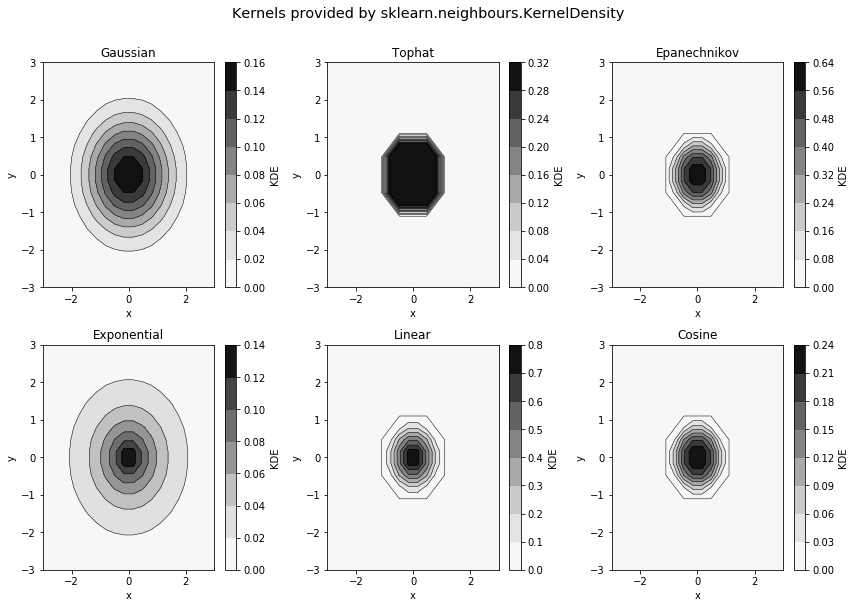

In [14]:
plotKernels2d()

Now we'll use `meshgrid` to generate a set of sampling points that are appropriate for our 2D model of the _Sloan Great Wall_ dataset.

In [15]:
greatWallXYGrids = [
    np.linspace(
        greatWallXY[:, dimensionIndex].min(),
        greatWallXY[:, dimensionIndex].max(),
        100,
    )
    for dimensionIndex in range(greatWallXY.shape[1])
]

binArea = np.asscalar(
    np.diff(greatWallXYGrids[0][:2]) * np.diff(greatWallXYGrids[1][:2])
)

greatWallXYMesh = np.array(np.meshgrid(*greatWallXYGrids))

To start with, let's compute the KDE using a _Gaussian_ kernel using the default bandwidth.

In [16]:
greatWallKde = skneigh.KernelDensity(kernel="gaussian").fit(greatWallXY)

greatWallKdeModel = np.exp(
    greatWallKde.score_samples(greatWallXYMesh.T.reshape((100 * 100, 2)))
).reshape((100, 100))

We can plot the resultant model using filled contours as before

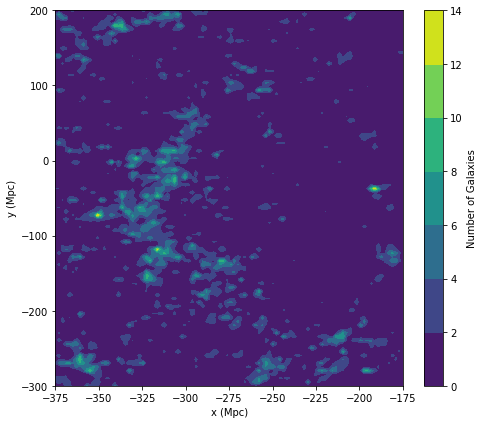

In [17]:
greatWallKdeAxes = mplplot.figure(figsize=(7, 6)).add_subplot(1, 1, 1)
contourData = greatWallKdeAxes.contourf(
    greatWallXYMesh.T[:, :, 0],
    greatWallXYMesh.T[:, :, 1],
    greatWallKdeModel * binArea * greatWallXY[:, 0].size,
    cmap="viridis",
)

greatWallKdeColourBar = mplplot.colorbar(contourData, ax=greatWallKdeAxes)
greatWallKdeColourBar.set_label("Number of Galaxies")
greatWallKdeAxes.set_xlabel("x (Mpc)")
greatWallKdeAxes.set_ylabel("y (Mpc)")
mplplot.tight_layout()

The default bandwidth looks like it might be a bit too small. Let's use cross validation to search for a better value. The procedure is identical to the 1D case. Now we start to see the advantages of a two dimensional data format requirement, which seemed annoying when we only had 1D data!

In [18]:
## Define the set of bandwidths to consider. We'll only use 20 this time
## because cross-validation for large datasets can be time consuming.
parameters2D = {"bandwidth": np.logspace(-3, 1, 20)}

crossValidator2D = skmodsel.GridSearchCV(
    estimator=skneigh.KernelDensity(kernel="gaussian"),
    param_grid=parameters2D,
    cv=5,
    iid=True,
)

crossValidator2D.fit(greatWallXY)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'bandwidth': array([1.00000e-03, 1.62378e-03, 2.63665e-03, 4.28133e-03, 6.95193e-03,
       1.12884e-02, 1.83298e-02, 2.97635e-02, 4.83293e-02, 7.84760e-02,
       1.27427e-01, 2.06914e-01, 3.35982e-01, 5.45559e-01, 8.85867e-01,
       1.43845e+00, 2.33572e+00, 3.79269e+00, 6.15848e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Now we can sample the model generated by the estimator with the optimal `bandwidth` parameter value.

In [19]:
bestGreatWallKdeModel = np.exp(
    crossValidator2D.best_estimator_.score_samples(
        greatWallXYMesh.T.reshape((100 * 100, 2))
    )
).reshape((100, 100))

Let's make a contour plot of our optimal model.

(8014, 2)


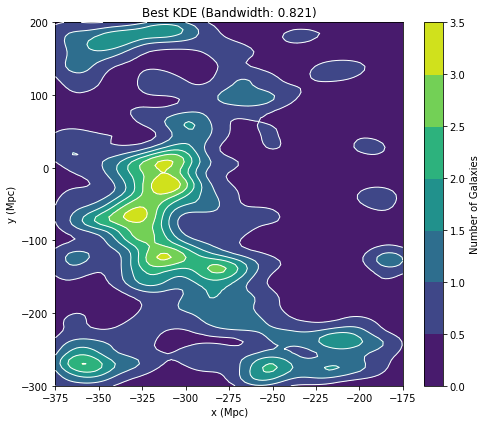

In [20]:
greatWallBestKdeAxes = mplplot.figure(figsize=(7, 6)).add_subplot(1, 1, 1)
filledContourData = greatWallBestKdeAxes.contourf(
    greatWallXYMesh.T[:, :, 0],
    greatWallXYMesh.T[:, :, 1],
    bestGreatWallKdeModel * binArea * greatWallXY[:, 0].size,
)

greatWallBestKdeColourBar = mplplot.colorbar(
    filledContourData, ax=greatWallBestKdeAxes
)

contourData = greatWallBestKdeAxes.contour(
    greatWallXYMesh.T[:, :, 0],
    greatWallXYMesh.T[:, :, 1],
    bestGreatWallKdeModel * binArea * greatWallXY[:, 0].size,
    colors="w",
    linewidths=1,
    zorder=100,
)

greatWallBestKdeColourBar.set_label("Number of Galaxies")
greatWallBestKdeAxes.set_xlabel("x (Mpc)")
greatWallBestKdeAxes.set_ylabel("y (Mpc)")
greatWallBestKdeAxes.set_title(
    "Best KDE (Bandwidth: {bandwidth:.3f})".format(
        **crossValidator.best_params_
    )
)
mplplot.tight_layout()

Finally, let's just check the effect of the 2D kernel shape on the model fit.

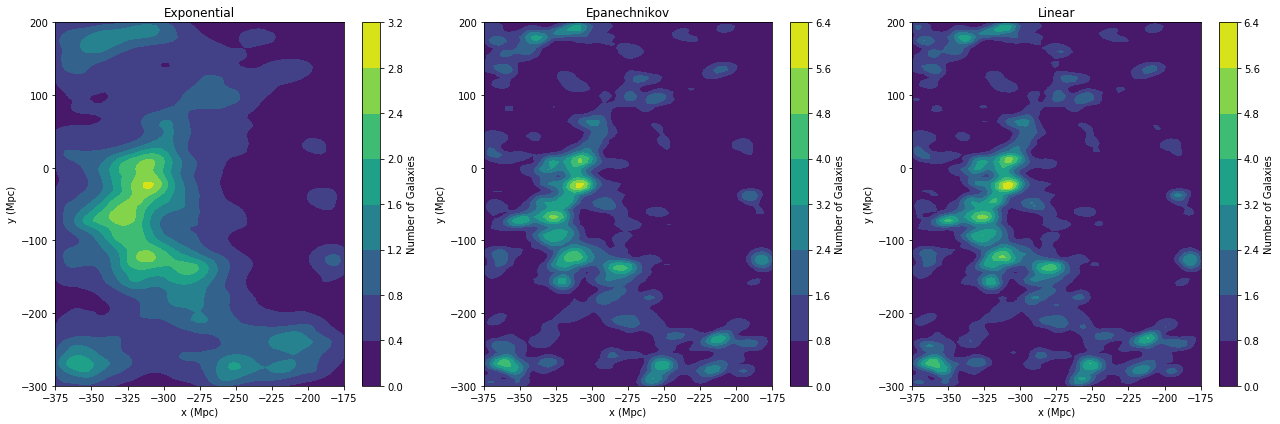

In [26]:
randomKernels = np.random.choice(alternateKernelNames, 3, replace=False)

test2DKernelFigure, test2DKernelPanels = mplplot.subplots(
    figsize=(18, 6), nrows=1, ncols=randomKernels.size
)

for randomKernel, test2DKernelPanel in zip(
    randomKernels, test2DKernelPanels.flatten()
):
    testKernel2DModel = np.exp(
        skneigh.KernelDensity(
            kernel=randomKernel, **crossValidator2D.best_params_
        )
        .fit(greatWallXY)
        .score_samples(greatWallXYMesh.T.reshape((100 * 100, 2)))
    ).reshape((100, 100))

    contourData = test2DKernelPanel.contourf(
        greatWallXYMesh.T[:, :, 0],
        greatWallXYMesh.T[:, :, 1],
        testKernel2DModel * binArea * greatWallXY[:, 0].size,
    )
    testKernel2DColourBar = mplplot.colorbar(contourData, ax=test2DKernelPanel)
    testKernel2DColourBar.set_label("Number of Galaxies")

    test2DKernelPanel.set_title(randomKernel.title())
    test2DKernelPanel.set_xlabel("x (Mpc)")
    test2DKernelPanel.set_ylabel("y (Mpc)")
mplplot.tight_layout()